In [11]:
#importing libraries
import pandas as pd
%pylab inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6 #setting figsize

Populating the interactive namespace from numpy and matplotlib


In [13]:
#importing dataset
from datetime import datetime
df=pd.read_csv('/home/c5it/Documents/Time_Series_ARIMA--Blog-and-code--master/AirPassengers.csv',parse_dates=['Month'],index_col=['Month'])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [14]:
df.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


Data from 1949-1960

steps-
1. Remove any trend and seasonality and make the ts stationary
2. Applying statistical forecasting to the stationary ts
3. finally converting the forecasted values into original by applying the trend and seasonality constrains.


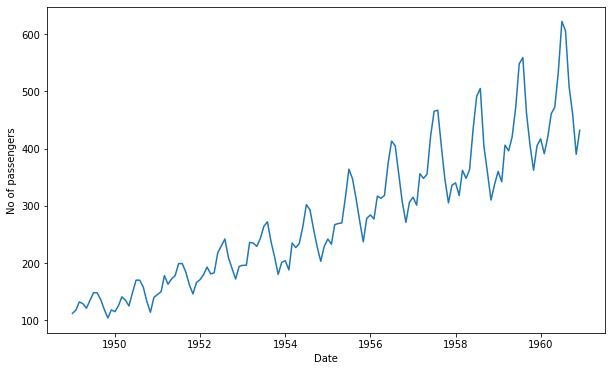

In [15]:
#plotting graph
plt.xlabel('Date')
plt.ylabel('No of passengers')
plt.plot(df)

In [16]:
# there is an upward trend, non- stationary(means are different at different intervals)

Stationarity tests

In [18]:
# rolling stats test
rollmean=df.rolling(window=12).mean() #window for 12 months i.e last one year for each year respectively
rollstd=df.rolling(window=12).std()

print(rollmean,'\n',rollstd)


            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns] 
             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


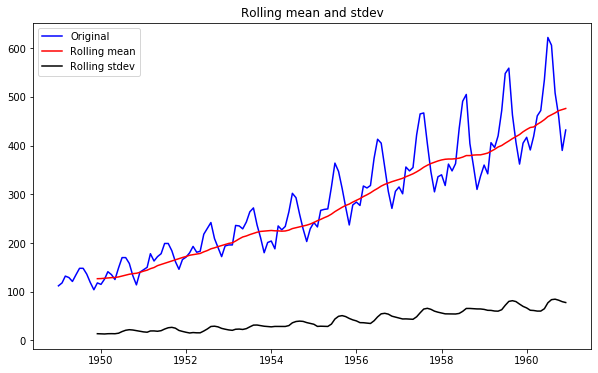

In [19]:
# plotting the rolling stats
orig=plt.plot(df,color='blue',label='Original')
mean=plt.plot(rollmean,color='red',label='Rolling mean')
std=plt.plot(rollstd,color='black',label='Rolling stdev')
plt.legend(loc='best') # picking labels from orig,mean and std
plt.title('Rolling mean and stdev')
plt.show()

In [20]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [21]:
# performing dicky fuller test

from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller test:')
dftest=adfuller(df['#Passengers'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical values %s'%(key)]=value
    
print(dfoutput)

Results of Dickey-Fuller test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of observations used    130.000000
critical values 1%              -3.481682
critical values 5%              -2.884042
critical values 10%             -2.578770
dtype: float64


Since critical values are less than the test statistic and p-value is >0.5, we fail to reject the null hypothesis
and thus- data is non stationary

Let’s start by working on the trend part.

The first step is to reduce the trend using transformation, as we can see here that there is a strong positive trend.
Let's use logarithmic transformation which penalizes larger values more than the smaller.

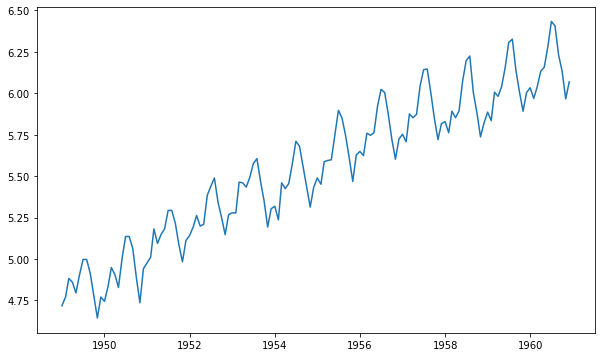

In [22]:
# Estimating the trend by taking a log
df_logscale=np.log(df)
plt.plot(df_logscale)

There is some noise in realizing the forward trend here.
There are some methods to model these trends and then remove them from the series.

• Smoothing: using rolling/moving average

• Aggression: by taking the mean for a certain time period (year/month)

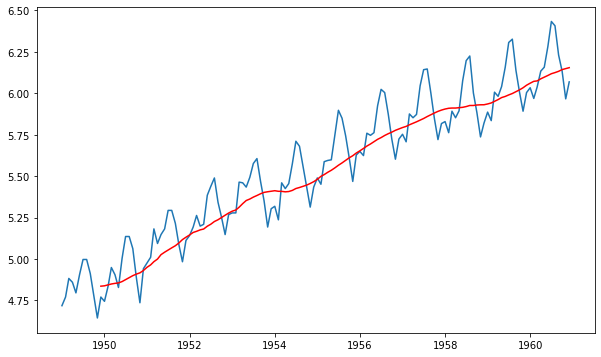

In [24]:
# Smoothing- 1. Computing moving averages for log
movingAverage=df_logscale.rolling(window=12).mean()
movingstd=df_logscale.rolling(window=12).std()
plt.plot(df_logscale)
plt.plot(movingAverage,color='red')


In [25]:
# 2.- Take difference between actual no of passengers and moving averages
log_diff=df_logscale-movingAverage
# removing nan values
log_diff.dropna(inplace=True)
log_diff.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


In [26]:
# creating a function to perform the stationarity test

In [27]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd =  timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%(key)] = value
    print (dfoutput)

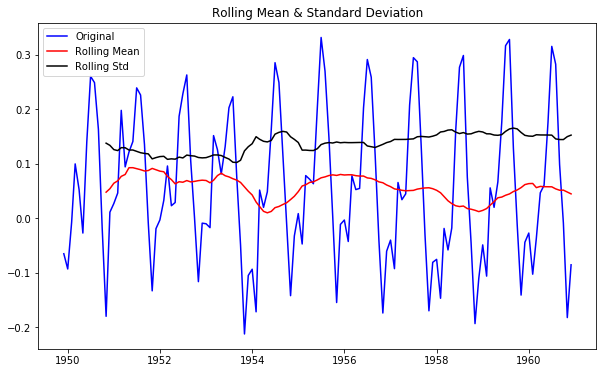

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [28]:
test_stationarity(log_diff)

 p value is less than 0.5 and test stat is almost equal to critical value 

• The rolling values are varying slightly but there is no specific trend.

• The test statistics is smaller than the 5 % critical values. That tells us that we are 95% confident that this series is stationary.

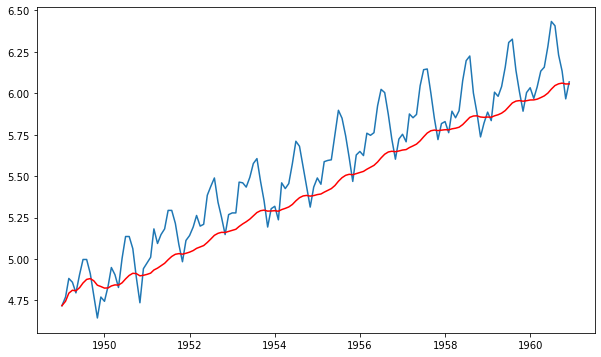

In [37]:
# exponential moving avgs
exp_wdf=df_logscale.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(df_logscale)
plt.plot(exp_wdf,color='red')

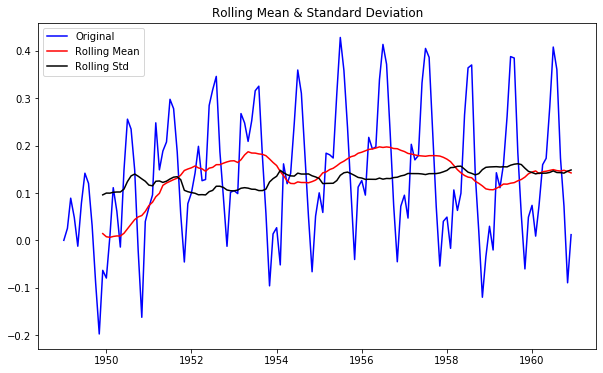

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [38]:
wdf_diff=df_logscale-exp_wdf
test_stationarity(wdf_diff)

Stationary because:

• Rolling values have less variations in mean and standard deviation in magnitude.

• the test statistic is smaller than 1% of the critical value. So we can say we are almost 99% confident that the ts is stationary.

Seasonality (along with Trend)

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

Differencing – taking the difference with a particular time lag

Decomposition – modeling both trend and seasonality and removing them from the model.

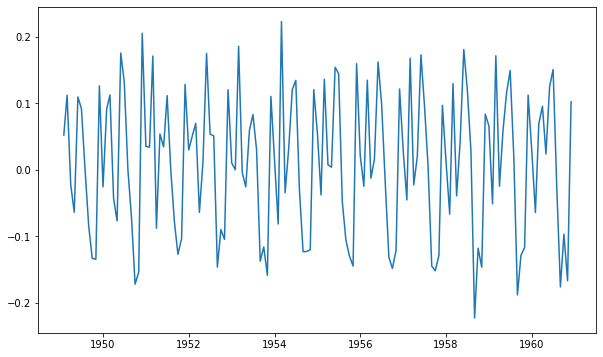

In [41]:
# performing differencing
log_differencing=df_logscale-df_logscale.shift()
plt.plot(log_differencing)

In [43]:
log_differencing.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022


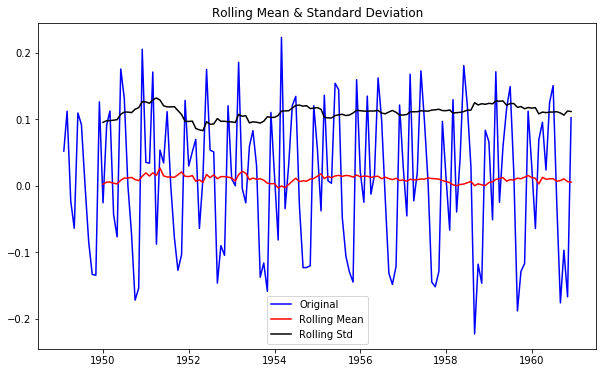

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [44]:
# testing stationarity
log_differencing.dropna(inplace=True)
test_stationarity(log_differencing)

• the mean and std variations have small variations with time.

• test statistic is less than 10% of the critical values, so we can be 90 % confident that this is stationary.

Decomposing:

Modelling both the trend and the seasonality

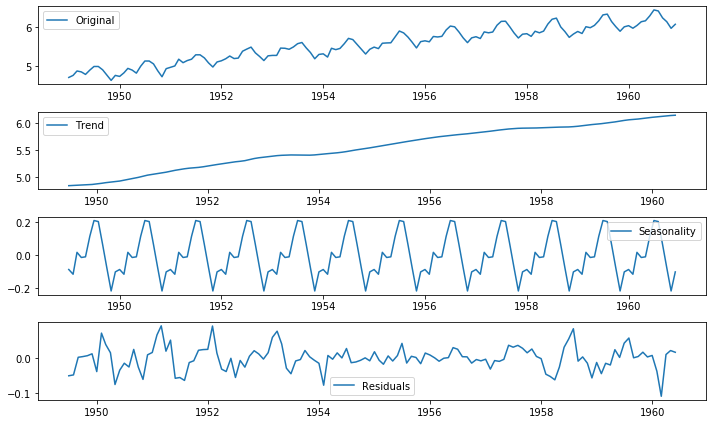

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_logscale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_logscale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

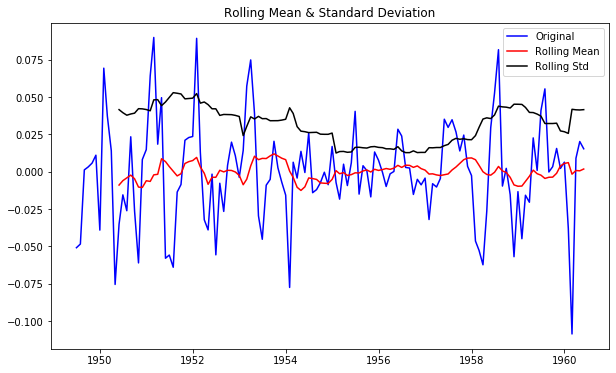

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [76]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

• test statistic is lower than 1% critical values.

• the mean and std variations have small variations with time.

## Forecasting the Time Series

Now that we have made the Time series stationary, let’s make models on the time series using differencing because it is easy to add the error , trend and seasonality back into predicted values .

1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

2.Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

3.Number of Differences (d): These are the number of nonseasonal differences.

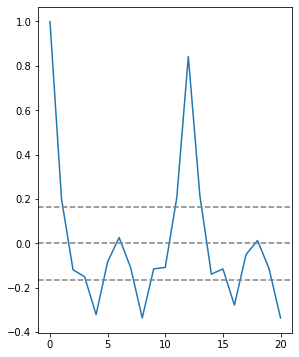

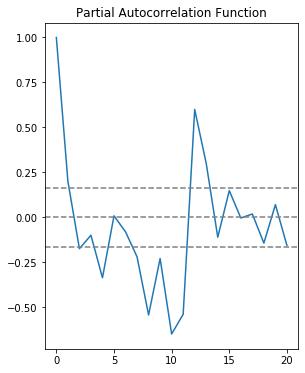

<Figure size 720x432 with 0 Axes>

In [79]:
# plotting the acf and pacf graphs to get the optimal values of q and p respectively

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(log_differencing, nlags=20)
lag_pacf = pacf(log_differencing, nlags=20, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_differencing)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_differencing)),linestyle='--',color='gray')
plt.show()
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_differencing)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_differencing)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()
plt.tight_layout()

The two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values as:

• p: The first time where the PACF crosses the upper confidence interval, here its close to 2. hence p = 2.

• q: The first time where the ACF crosses the upper confidence interval, here its close to 2. hence q = 2.

# Applying Arima(AR, MA and ARIMA models)

In [ ]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

In [170]:
log_differencing.head()

,#Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484


Text(0.5, 1.0, 'RSS: 1.5023')

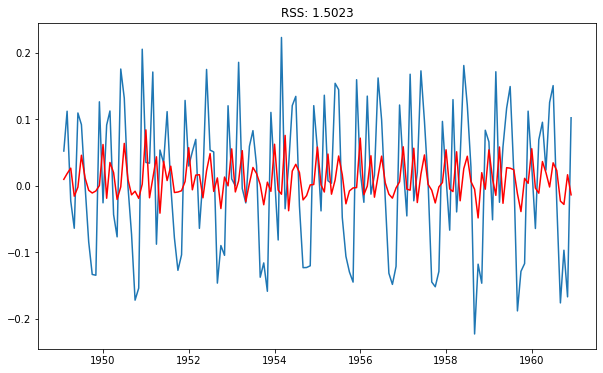

In [128]:
#AR model
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df_logscale,order=(2,1,0),freq=df_logscale.index.inferred_freq)
results_AR=model.fit(disp=-1)
plt.plot(log_differencing)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-log_differencing['#Passengers'])**2))

Text(0.5, 1.0, 'RSS: 1.4721')

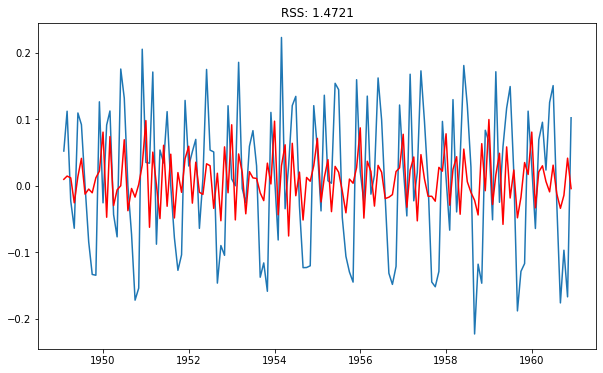

In [129]:
#MA Model
model=ARIMA(df_logscale,order=(0,1,2),freq=df_logscale.index.inferred_freq)
results_MA=model.fit(disp=-1)
plt.plot(log_differencing)
plt.plot(results_MA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-log_differencing['#Passengers'])**2))

Text(0.5, 1.0, 'RSS: 1.0292')

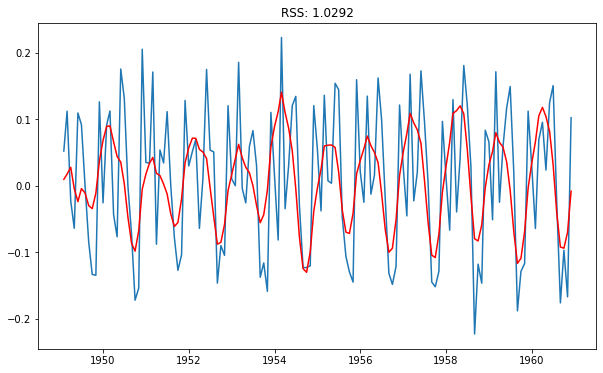

In [130]:
# ARIMA Model
model=ARIMA(df_logscale,order=(2,1,2),freq=df_logscale.index.inferred_freq)
results_ARIMA=model.fit(disp=-1)
plt.plot(log_differencing)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_differencing['#Passengers'])**2))

Taking it back to original scale



In [131]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [133]:
# january month is missing because of differencing, taking a cumulative sum to bring back to original scale
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [166]:
#adding the first value/january month(base value) and adding the cumulative sum  to the series

predictions_ARIMA_log=pd.Series(df_logscale['#Passengers'][0],index=df_logscale.index)
#predictions_ARIMA_log[0]=df_logscale.iloc[0]
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1047')

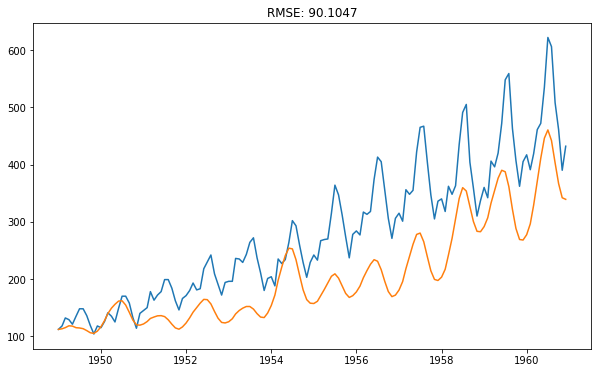

In [169]:
# taking the exponent of the series (anti-log) which will be the predicted value 
# calculating the RMSE

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df['#Passengers'])**2)/len(df)))